# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import stats
import numpy as np

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

In [2]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()


cutoff = pd.Timestamp("2026-02-03 11:10:55.661533+00", tz="UTC")
df_raw = df_raw[pd.to_datetime(df_raw["created_at"], utc=True) >= cutoff]

display(df_raw)
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
24,67c36565-ecf2-4655-a5f6-d3e86b19dcc6,5dd2ccf12e6c772de06f525b,profile_23_last,completed,2026-02-03T11:13:06.096269+00:00,"[{'rt': 1722, 'study_id': '6962232f30c21461e6a...",1770117186247,1770116663290,31
25,cc408b35-1a37-439d-8e76-11ba7a596404,697a5d3fb0c089ca2e54958a,profile_33_first,completed,2026-02-03T11:13:13.411361+00:00,"[{'rt': 23496, 'study_id': '6962232f30c21461e6...",1770117192502,1770116696579,52
26,53f4d379-699c-4a1b-9fdf-e177887c638f,5f3adfbf2e598b7a0b73c45e,profile_20_last,completed,2026-02-03T11:13:19.079171+00:00,"[{'rt': 5852, 'study_id': '6962232f30c21461e6a...",1770117197118,1770116662731,25
46,d39b2495-ab78-47d9-8ab6-55f7ac40ca2b,5e3ddcf95556b204cb143eab,profile_29_last,completed,2026-02-03T11:13:27.843382+00:00,"[{'rt': 15900, 'study_id': '6962232f30c21461e6...",1770117207663,1770116680483,43
47,7fa24d31-ea02-4cd4-8b82-5afbfeb09072,6658b32dd8c3da854c842802,profile_14_last,completed,2026-02-03T11:13:37.649977+00:00,"[{'rt': 5467, 'study_id': '6962232f30c21461e6a...",1770117216893,1770116783947,11
...,...,...,...,...,...,...,...,...,...
240,2702223e-cd3a-48f4-b783-a9ccad6902a7,696abe3b7d7f518c6540fa45,profile_35_first,completed,2026-02-07T14:52:11.717503+00:00,"[{'rt': 20172, 'study_id': '6980c852b1ec006643...",1770475930203,1770475194488,35
241,80a3704a-8168-440b-9d78-7bde71e801fa,604db6324496c57afe822770,profile_18_last,completed,2026-02-07T14:54:16.791672+00:00,"[{'rt': 8493, 'study_id': '6980c852b1ec006643f...",1770476056092,1770475102273,20
242,d6a5cde0-922f-4d55-866a-7d6dd3249c0d,665ee374604d2c5d4d858efd,profile_32_first,completed,2026-02-07T14:57:42.397018+00:00,"[{'rt': 8443, 'study_id': '6980c852b1ec006643f...",1770476261089,1770475460953,45
243,b48ecd00-c2c4-423c-ab8a-57e4a041b14e,5e8b9c7054a5cc07dd6e174d,profile_33_last,completed,2026-02-07T15:11:34.542454+00:00,"[{'rt': 12669, 'study_id': '6980c852b1ec006643...",1770477094161,1770476477662,46


(161, 9)


In [3]:
# Dataframe from 10 prolific test participants, only one "certainty" trial per participant and wrong response time tracking
df_prolific_test = pd.DataFrame(rows)

# Drop all test and debug participants
df_prolific_test = df_prolific_test[(~df_prolific_test['prolific_pid'].str.startswith('DEBUG')) &
    (~df_prolific_test['prolific_pid'].str.startswith('TEST_'))
].copy()

start_cutoff = pd.Timestamp("2026-01-28 12:50:00+00:00", tz="UTC")
main_cutoff  = pd.Timestamp("2026-02-02 11:10:55.661533+00", tz="UTC")

df_prolific_test["created_at"] = pd.to_datetime(df_prolific_test["created_at"], utc=True)

df_prolific_test = df_prolific_test[
    (df_prolific_test["created_at"] >= start_cutoff)
    & (df_prolific_test["created_at"] <  main_cutoff)
]


display(df_prolific_test)
print(df_prolific_test.shape)

profiles_raw = set(df_raw["profile_id"].dropna().astype(str))
profiles_extra = set(df_prolific_test["profile_id"].dropna().astype(str))

overlap = profiles_raw & profiles_extra

print("Profiles in df_raw:", len(profiles_raw))
print("Profiles in df_prolific_test:", len(profiles_extra))
print("Overlapping profiles:", len(overlap))

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
73,9c0d06ee-31ab-4c79-9f29-60340eb12bc2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,2026-01-28 12:57:10.075912+00:00,"[{'rt': 11700, 'study_id': '6962232f30c21461e6...",1769605029862,1769604712731,67
74,cae0bb77-d57a-41ca-8dd0-f86f78a6d8da,5a381de00006450001bf2691,profile_17_last,completed,2026-01-28 13:01:09.976787+00:00,"[{'rt': 14626, 'study_id': '6962232f30c21461e6...",1769605269189,1769604706487,17
75,5234326d-6ea1-49fb-93af-ee75e3984bec,676061b0d6e01e2e9548a4b9,profile_23_last,completed,2026-01-28 13:01:43.657952+00:00,"[{'rt': 21763, 'study_id': '6962232f30c21461e6...",1769605302694,1769604839827,31
76,da575643-83eb-4e38-80ce-03c10cd672cd,5bf8a27021a4e1000194fc76,profile_2_last,completed,2026-01-28 13:06:27.084044+00:00,"[{'rt': 14676, 'study_id': '6962232f30c21461e6...",1769605586286,1769605024569,45
77,22802372-74d0-411e-b879-ad9fdd2cf510,6146548679f86b7cb069e7f7,profile_11_last,completed,2026-01-28 13:07:56.910077+00:00,"[{'rt': 17468, 'study_id': '6962232f30c21461e6...",1769605676363,1769604826317,5
78,8d8195d4-b457-4dc8-8759-55a0fd0bdd29,5c5cad3e4ee81200018eafe2,profile_33_last,completed,2026-01-28 13:08:39.759393+00:00,"[{'rt': 12588, 'study_id': '6962232f30c21461e6...",1769605719886,1769604862872,53
79,1a28d289-0ebb-4d80-8695-5706704a0021,6053e01a6a8e8516ba7d47a7,profile_3_first,completed,2026-01-28 13:11:20.176687+00:00,"[{'rt': 17185, 'study_id': '6962232f30c21461e6...",1769605879714,1769604911837,60
80,af0da243-8692-4325-8db2-4342e07029c7,571bdaa76b0894001362f780,profile_7_first,completed,2026-01-28 13:15:48.124049+00:00,"[{'rt': 1575, 'study_id': '6962232f30c21461e6a...",1769606146541,1769605546811,68
81,6950a956-3a7a-4d54-ada1-1895374aa902,676063838d4db0d3eaa69c2b,profile_13_last,completed,2026-01-28 13:17:42.084933+00:00,"[{'rt': 1414, 'study_id': '6962232f30c21461e6a...",1769606181795,1769605539794,9
82,7c24ad90-a9d6-44d4-80d1-ea16478e0096,61517db6a7589569521b2356,profile_35_first,failed_attention,2026-01-28 13:24:27.069578+00:00,"[{'rt': 28624, 'study_id': '6962232f30c21461e6...",1769606665652,1769605461409,56


(12, 9)
Profiles in df_raw: 69
Profiles in df_prolific_test: 12
Overlapping profiles: 12


In [4]:
# Missing profiles from the main prolific run are filled up by 5 volunteers
df_volunteers = pd.DataFrame(rows)

# Drop all test and debug participants
df_volunteers = df_volunteers[(~df_volunteers['prolific_pid'].str.startswith('DEBUG')) &
    (df_volunteers['prolific_pid'].str.startswith('TEST_') & (df_volunteers['prolific_pid'] != 'TEST_1'))
].copy()

start_cutoff = pd.Timestamp("2026-02-08 07:43:32.570752+00", tz="UTC")
main_cutoff  = pd.Timestamp("2026-02-13 12:16:49.701037+00", tz="UTC")

df_volunteers["created_at"] = pd.to_datetime(df_volunteers["created_at"], utc=True)

df_volunteers = df_volunteers[
    (df_volunteers["created_at"] >= start_cutoff)
    & (df_volunteers["created_at"] <=  main_cutoff)
]

df_volunteers["created_at"] = pd.to_datetime(df_volunteers["created_at"], utc=True)

df_volunteers = df_volunteers[
    (df_volunteers["created_at"] >= cutoff)
]

# Exclude one volunteer that took a very long time to complete the study
df_volunteers= df_volunteers[df_volunteers['prolific_pid'] != 'TEST_a6c6492a-1f45-4588-b613-f5c042653d14']

display(df_volunteers)
print(df_volunteers.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
245,6d93eb19-303f-4090-9445-6a36d5491cbe,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,2026-02-08 07:43:32.570752+00:00,"[{'rt': 31143, 'exit_time': 1770536611298, 'ti...",1770536611298,1770535783798,61
246,0a7b287c-14ab-4421-8126-468965d1d8c2,TEST_6fde0f1f-6fd3-4f1e-8910-6f0f4f74fd32,profile_15_last,completed,2026-02-08 09:03:30.270853+00:00,"[{'rt': 35452, 'exit_time': 1770541408185, 'ti...",1770541408185,1770540674588,69
249,344e7442-344f-4e2f-ad49-5a616e254264,TEST_fe9bf5a0-a286-4fd7-9277-3c3a769f8108,profile_36_last,failed_attention,2026-02-10 14:45:15.544133+00:00,"[{'rt': 2338, 'exit_time': 1770734713917, 'tim...",1770734713917,1770734252712,2
250,9b4e7b50-b3ce-4fea-bdbc-d4a239d3fbe4,TEST_dfadd2b8-6972-445d-b2ba-c0e58d75d5a8,profile_36_last,completed,2026-02-11 15:36:24.178034+00:00,"[{'rt': 26643, 'exit_time': 1770824182580, 'ti...",1770824182580,1770823420052,2
251,ec6d0668-e51b-4e0e-bd38-e83d829bd1fb,TEST_77ef0348-c4de-435f-ab81-95737f112ff1,profile_25_last,failed_distractor,2026-02-11 16:02:49.200195+00:00,"[{'rt': 80013, 'exit_time': 1770825767264, 'ti...",1770825767264,1770825177517,13
252,c7528e07-4a77-401e-996b-f1ed6a9c5d7d,TEST_8b185b98-7823-4f8f-a50d-cb24aaee8b67,profile_25_last,completed,2026-02-11 22:05:22.349680+00:00,"[{'rt': 9761, 'exit_time': 1770847520331, 'tim...",1770847520331,1770846314194,13
253,f108e510-46a5-4cc4-8108-fd09e64db2c0,TEST_1d0e4153-c4e9-44c0-8ef2-7e18a66ae979,profile_2_first,failed_distractor,2026-02-12 19:25:36.198116+00:00,"[{'rt': 1580, 'exit_time': 1770924338500, 'pro...",1770924338500,1770924325465,70
254,4f561cbc-a003-49a4-ba06-aecae60000a0,TEST_93d01129-bdc6-4c84-a048-0b694b9ed3cd,profile_2_first,completed,2026-02-12 20:48:20.021390+00:00,"[{'rt': 29067, 'exit_time': 1770929297958, 'ti...",1770929297958,1770928344352,70
255,7c390a16-82ea-4fa1-9652-52ff715d50c3,TEST_9a2708b2-a813-499c-8037-935b64837ccf,profile_2_first,failed_distractor,2026-02-13 11:44:59.473807+00:00,"[{'rt': 1808, 'exit_time': 1770983098344, 'tim...",1770983098344,1770983045394,70
256,fced2f8a-d134-4cb1-8b79-df1a7ce4046e,TEST_09945e53-dec4-44d4-998d-1834371d1b05,profile_2_first,completed,2026-02-13 12:16:49.701037+00:00,"[{'rt': 26336, 'exit_time': 1770985007193, 'ti...",1770985007193,1770984476366,70


(10, 9)


profile_id
profile_23_last     5
profile_20_last     5
profile_5_first     5
profile_28_first    5
profile_9_first     4
                   ..
profile_35_first    1
profile_18_last     1
profile_32_first    1
profile_33_last     1
profile_14_first    1
Name: count, Length: 69, dtype: int64


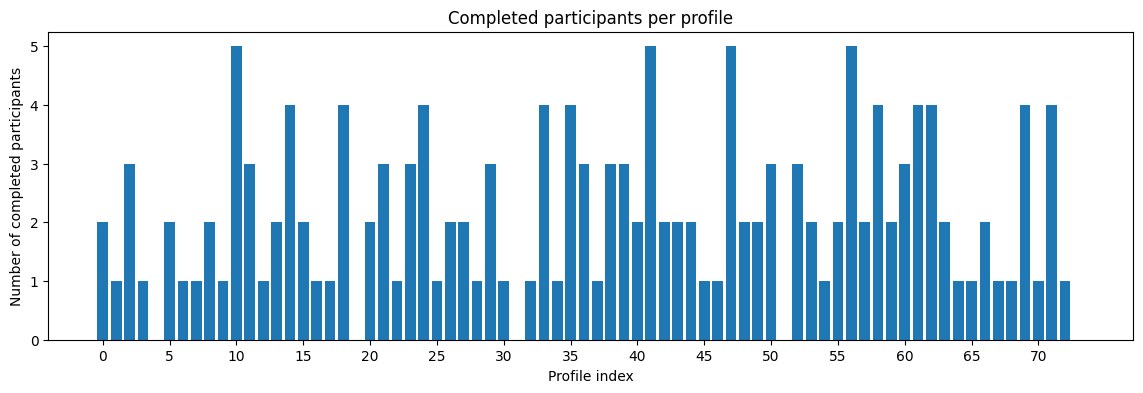

In [5]:
N_PROFILES = 37
intro_positions = ["first", "last"]

all_profiles = [
    f"profile_{i}_{pos}"
    for i in range(N_PROFILES)
    for pos in intro_positions
]

completed = df_raw[df_raw["exit_reason"] == "completed"]

profile_counts = (
    completed["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)
print(df_raw[df_raw["exit_reason"] == "completed"]["profile_id"].value_counts())

fig, ax = plt.subplots(figsize=(14, 4))

ax.bar(range(len(profile_counts)), profile_counts.values)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile")

step = 5  # show every 5th profile
ax.set_xticks(range(0, len(profile_counts), step))
ax.set_xticklabels(range(0, len(profile_counts), step))

plt.show()


In [6]:
profile_counts[profile_counts == 0]

profile_id
profile_2_first    0
profile_9_last     0
profile_15_last    0
profile_25_last    0
profile_36_last    0
Name: count, dtype: int64

In [7]:
df_extra = pd.concat([df_prolific_test, df_volunteers], ignore_index=True)

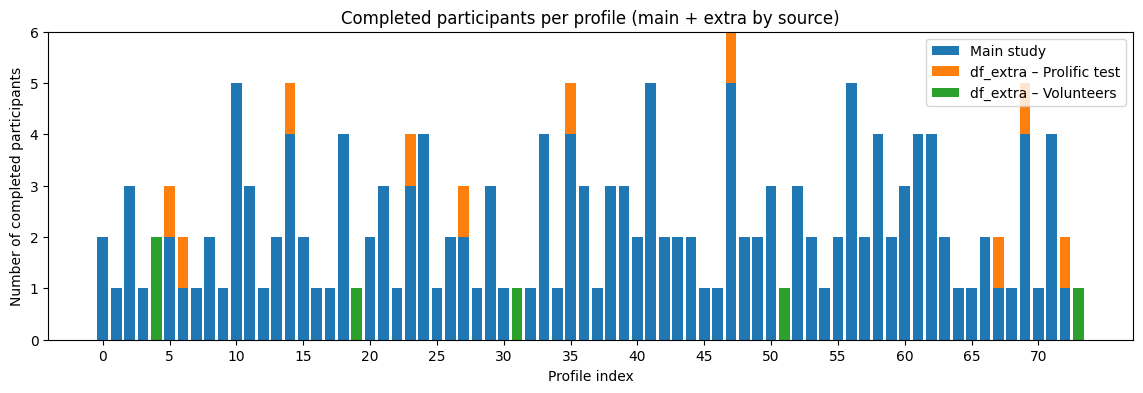

In [8]:
N_PROFILES = 37
intro_positions = ["first", "last"]

all_profiles = [
    f"profile_{i}_{pos}"
    for i in range(N_PROFILES)
    for pos in intro_positions
]

# main study
completed_raw = df_raw[df_raw["exit_reason"] == "completed"]

profile_counts_raw = (
    completed_raw["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

# extra
# df_extra successful completions only
completed_extra = df_extra[df_extra["exit_reason"] == "completed"]

# volunteers
completed_extra_volunteers = completed_extra[
    completed_extra["prolific_pid"].str.startswith("TEST_")
]

# prolific test run
completed_extra_prolific = completed_extra[
    ~completed_extra["prolific_pid"].str.startswith("TEST_")
]

profile_counts_extra_volunteers = (
    completed_extra_volunteers["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

profile_counts_extra_prolific = (
    completed_extra_prolific["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 4))

x = range(len(all_profiles))

# base: main study
ax.bar(
    x,
    profile_counts_raw.values,
    label="Main study",
)

# middle: df_extra (Prolific test)
ax.bar(
    x,
    profile_counts_extra_prolific.values,
    bottom=profile_counts_raw.values,
    label="df_extra – Prolific test",
    color="tab:orange",
)

# top: df_extra (volunteers)
ax.bar(
    x,
    profile_counts_extra_volunteers.values,
    bottom=profile_counts_raw.values + profile_counts_extra_prolific.values,
    label="df_extra – Volunteers",
    color="tab:green",
)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile (main + extra by source)")

step = 5
ax.set_xticks(range(0, len(all_profiles), step))
ax.set_xticklabels(range(0, len(all_profiles), step))

ax.legend()
plt.show()

In [9]:
# Explode df_raw into trial-level df 
def explode_trials(df):
    rows = []

    for _, row in df.iterrows():
        pid = row["prolific_pid"]
        profile_id = row["profile_id"]
        exit_reason = row["exit_reason"]

        if profile_id.endswith("_first"):
            intro_position = "first"
        elif profile_id.endswith("_last"):
            intro_position = "last"
        else:
            intro_position = None

        for trial in row["data"]:
            flat = {
                "PROLIFIC_PID": pid,
                "profile_id": profile_id,
                "exit_reason": exit_reason,
                "intro_position": intro_position,
            }
            flat.update(trial)
            rows.append(flat)

    df = pd.DataFrame(rows)
    df = df.dropna(axis=1, how="all")

    display(df.head(10))
    print("Shape:", df.shape)

    return df

df_volunteers_trials = explode_trials(df_volunteers)
df_prolific_test_trials = explode_trials(df_prolific_test)
df_raw_trials = explode_trials(df_raw)

,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,exit_time,timed_out,subject_id,trial_type,trial_index,...,second_certainty_time,certainty_change_count,passed,response,sanity_id,question_order,response_index,correct_response,stimulus,slider_start
0,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,31143.0,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,instructions,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,1,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,2,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,3,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,4,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,9730.0,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,survey-likert,5,...,NaN,NaN,True,{'Q0': 4},1.0,[0],4.0,Strongly Disagree,NaN,NaN
6,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,6,...,10863.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,7,...,7175.9,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,8,...,13806.8,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,last,NaN,1770536611298,True,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,html-button-response,9,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (819, 41)


,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,study_id,exit_time,timed_out,session_id,subject_id,...,variant_region,percent_colored,passed,response,sanity_id,question_order,response_index,correct_response,stimulus,slider_start
0,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,11700.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,4725.0,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,NaN,NaN,True,{'Q0': 4},1.0,[0],4.0,Strongly Disagree,NaN,NaN
6,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5997043dbbe84800017964a7,profile_6_last,failed_distractor,last,NaN,6962232f30c21461e6a14157,1769605029862,True,697a064c0ed7d9794f847401,5997043dbbe84800017964a7,...,FG,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (1189, 37)


,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,study_id,exit_time,timed_out,session_id,subject_id,...,second_certainty_time,certainty_change_count,passed,response,sanity_id,question_order,response_index,correct_response,stimulus,slider_start
0,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,1722.0,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,16150.0,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,NaN,True,{'Q0': 4},1.0,[0],4.0,Strongly Disagree,NaN,NaN
6,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (17056, 43)


In [10]:
# Adapt volunteers and prolific test trial dataframes to have the same columns as df_raw_trials, filling missing columns with NaN

# Drop legacy certainty everywhere
df_raw_trials = df_raw_trials.drop(columns=["certainty"], errors="ignore")

df_volunteers_trials = df_volunteers_trials.drop(
    columns=["certainty"],
    errors="ignore"
)
for col in ["session_id", "study_id"]:
    if col not in df_volunteers_trials.columns:
        df_volunteers_trials[col] = None

df_prolific_test_trials["initial_certainty"] = df_prolific_test_trials["certainty"]
df_prolific_test_trials["final_certainty"] = df_prolific_test_trials["certainty"]
df_prolific_test_trials["certainty_change_count"] = 1
df_prolific_test_trials["second_certainty_time"] = None
df_prolific_test_trials = df_prolific_test_trials.drop(columns=["certainty"])

for col in ["color_time", "finish_time", "first_certainty_time"]:
    if col not in df_prolific_test_trials.columns:
        df_prolific_test_trials[col] = None

df_raw_trials["study_type"] = "main"
df_prolific_test_trials["study_type"] = "prolific_test"
df_volunteers_trials["study_type"] = "volunteer"

# Final column alignment
reference_cols = sorted(
    set(df_raw_trials.columns)
    | set(df_prolific_test_trials.columns)
    | set(df_volunteers_trials.columns)
)

df_raw_trials = df_raw_trials.reindex(columns=reference_cols)
df_prolific_test_trials = df_prolific_test_trials.reindex(columns=reference_cols)
df_volunteers_trials = df_volunteers_trials.reindex(columns=reference_cols)

In [27]:
# Combine the all dataframes eto get the complete dataset for evaluation
trial_df = pd.concat(
    [df_raw_trials,
     df_prolific_test_trials,
     df_volunteers_trials],
    ignore_index=True
)

display(trial_df.head(10))

/tmp/ipykernel_3130144/408817195.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trial_df = pd.concat(


,PROLIFIC_PID,certainty_change_count,color_time,correct_response,distractor_errors,exit_reason,exit_time,experiment_start_time,final_certainty,finish_time,...,subject_id,target_color,task_type,time_elapsed,timed_out,timeout_time,trial_index,trial_type,variant_region,view_history
0,5dd2ccf12e6c772de06f525b,NaN,NaN,NaN,NaN,completed,1770117186247,1770116663290,NaN,NaN,...,5dd2ccf12e6c772de06f525b,NaN,NaN,1731,True,1.770117e+12,0,instructions,NaN,"[{'page_index': 0, 'viewing_time': 1721}]"
1,5dd2ccf12e6c772de06f525b,1.0,4524.9,NaN,0.0,completed,1770117186247,1770116663290,NaN,9561.4,...,5dd2ccf12e6c772de06f525b,red,color_judgment,11300,True,1.770117e+12,1,html-button-response,FG,NaN
2,5dd2ccf12e6c772de06f525b,1.0,3133.1,NaN,0.0,completed,1770117186247,1770116663290,NaN,6802.6,...,5dd2ccf12e6c772de06f525b,white,color_judgment,18107,True,1.770117e+12,2,html-button-response,BG,NaN
3,5dd2ccf12e6c772de06f525b,1.0,4097.5,NaN,0.0,completed,1770117186247,1770116663290,NaN,7002.5,...,5dd2ccf12e6c772de06f525b,red,color_judgment,25118,True,1.770117e+12,3,html-button-response,FG,NaN
4,5dd2ccf12e6c772de06f525b,1.0,2973.6,NaN,0.0,completed,1770117186247,1770116663290,NaN,5509.3,...,5dd2ccf12e6c772de06f525b,grey,color_judgment,30634,True,1.770117e+12,4,html-button-response,FG,NaN
5,5dd2ccf12e6c772de06f525b,NaN,NaN,Strongly Disagree,NaN,completed,1770117186247,1770116663290,NaN,NaN,...,5dd2ccf12e6c772de06f525b,NaN,sanity,46792,True,1.770117e+12,5,survey-likert,NaN,NaN
6,5dd2ccf12e6c772de06f525b,1.0,2721.5,NaN,0.0,completed,1770117186247,1770116663290,NaN,5793.8,...,5dd2ccf12e6c772de06f525b,pink,color_judgment,52592,True,1.770117e+12,6,html-button-response,FG,NaN
7,5dd2ccf12e6c772de06f525b,1.0,2117.2,NaN,0.0,completed,1770117186247,1770116663290,NaN,4443.9,...,5dd2ccf12e6c772de06f525b,yellow,color_judgment,57045,True,1.770117e+12,7,html-button-response,FG,NaN
8,5dd2ccf12e6c772de06f525b,1.0,1786.8,NaN,0.0,completed,1770117186247,1770116663290,NaN,3680.9,...,5dd2ccf12e6c772de06f525b,white,color_judgment,60731,True,1.770117e+12,8,html-button-response,FG,NaN
9,5dd2ccf12e6c772de06f525b,1.0,1935.8,NaN,0.0,completed,1770117186247,1770116663290,NaN,3830.4,...,5dd2ccf12e6c772de06f525b,green,color_judgment,64569,True,1.770117e+12,9,html-button-response,FG,NaN


In [43]:
# Double check if target_color and add manipulation_color
prior_df = pd.read_csv(
    DATA / "prolific_stimuli" / "stimulus_table_image_priors_prolific.csv"
)
counterfact_df = pd.read_csv(
    DATA / "prolific_stimuli" / "stimulus_table_counterfact_prolific.csv"
)
shape_df = pd.read_csv(
    DATA / "prolific_stimuli" / "stimulus_table_shapes_prolific.csv"
)
stimulus_master = pd.concat(
    [prior_df, counterfact_df, shape_df],
    ignore_index=True,
).rename(columns={"target_color": "target_color_stimulus"})

trial_df = trial_df.merge(
    stimulus_master[["image_path", "manipulation_color", "target_color_stimulus"]],
    on="image_path",
    how="left"
)

trial_df["target_color"] = trial_df["target_color_stimulus"]
trial_df = trial_df.drop(columns=["target_color_stimulus"])

In [46]:
# Get profile-level dataframe for combined study 
profile_df = (
    trial_df
    .groupby("PROLIFIC_PID", as_index=False)
    .first()
)

display(profile_df.head(10))

,PROLIFIC_PID,certainty_change_count,color_time,correct_response,distractor_errors,exit_reason,exit_time,experiment_start_time,final_certainty,finish_time,...,timeout_time,trial_index,trial_type,variant_region,view_history,manipulation_color_x,target_color_stimulus_x,manipulation_color_y,target_color_stimulus_y,manipulation_color
0,55a13a6ffdf99b6ec83c23b8,1.0,3570.4,Strongly Disagree,0.0,completed,1770118446915,1770116903914,9.0,13147.4,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 15034}]",green,green,green,green,green
1,562a00dac8ffc20012513fbe,1.0,13020.9,Strongly Disagree,0.0,completed,1770117407634,1770116900099,8.0,18038.5,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 20847}]",yellow,yellow,yellow,yellow,yellow
2,56fa7c2e51c6bf000ccb2954,1.0,13607.0,Strongly Disagree,0.0,completed,1770118096004,1770117180261,7.0,24372.0,...,1.770117e+12,0,instructions,BG,"[{'page_index': 0, 'viewing_time': 16564}]",red,white,red,white,red
3,571bdaa76b0894001362f780,1.0,NaN,Strongly Disagree,NaN,completed,1769606146541,1769605546811,9.0,NaN,...,1.769606e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 1574}]",brown,brown,brown,brown,brown
4,574da26c7f1e770007f42d11,1.0,6006.6,Strongly Disagree,1.0,completed,1770117277737,1770116668816,9.0,11279.8,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 3210}]",pink,pink,pink,pink,pink
5,579f55486475d400015ab683,1.0,5147.8,Strongly Disagree,0.0,completed,1770117495219,1770116666465,9.0,13070.2,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 26379}]",green,green,green,green,green
6,57b715b842195e000159f82b,1.0,5694.8,Strongly Disagree,0.0,completed,1770118210402,1770116792475,9.0,10631.5,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 1920}]",green,green,green,green,green
7,58954e2dc88c680001dd4b7e,1.0,2671.9,Strongly Disagree,0.0,completed,1770117351101,1770116811389,NaN,14125.6,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 32026}]",green,green,green,green,green
8,58c1ce3c3783090001b49355,1.0,3779.8,Strongly Disagree,0.0,completed,1770117169214,1770116669322,4.0,11639.4,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 7834}]",orange,orange,orange,orange,orange
9,58f669cefb4d7500014af69b,1.0,3401.2,Strongly Disagree,1.0,completed,1770117330002,1770116689955,NaN,11009.7,...,1.770117e+12,0,instructions,FG,"[{'page_index': 0, 'viewing_time': 18574}]",blue,blue,blue,blue,blue


In [47]:
print("Task type counts:")
print(trial_df["task_type"].value_counts())
print("\nExit reason counts:")
print(profile_df["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    17769
sanity              892
introspection       179
warning              41
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            173
failed_distractor      8
failed_attention       2
Name: count, dtype: int64


In [48]:
trial_df.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_trial.csv", index=False)
profile_df.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_profile.csv", index=False)

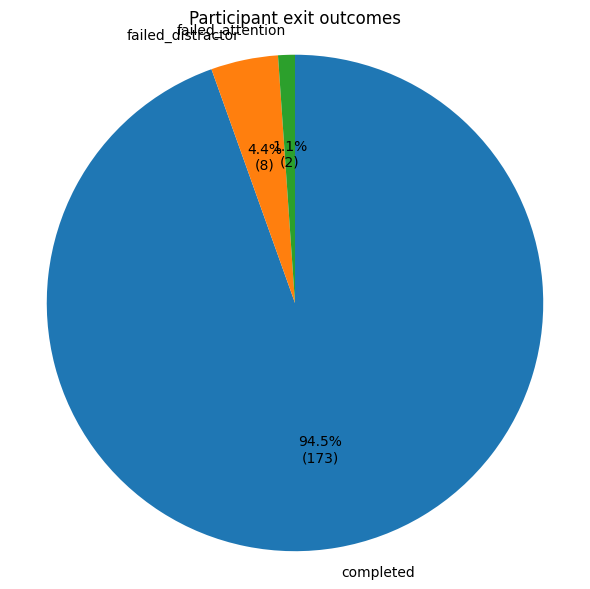

In [49]:
# Dropouts vs completions
exit_counts = profile_df['exit_reason'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    exit_counts,
    labels=exit_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100 * exit_counts.sum()))})",
    startangle=90,
    counterclock=False,
)
plt.title("Participant exit outcomes")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Failed by distractor colors

Number of failed trials: 15


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path
969,5e0f26b63ccda26295505f0d,rooster,FG,0.0,white,blue,color_images/gpt-4o/image_priors/rooster_3_c62...
1030,5e0f26b63ccda26295505f0d,square,FG,55.0,brown,blue,shapes/shape_colored/square_v1_brown/FG_055_se...
5892,6784133089e3f78e0e08c94d,hexagon,FG,60.0,purple,yellow,shapes/shape_colored/hexagon_v0_purple/FG_060_...
5900,6784133089e3f78e0e08c94d,beets,BG,40.0,white,red,color_images/gpt-4o/image_priors/beets_2_c2d24...
14621,677743bf62e157794cf97ff4,square,FG,50.0,grey,red,shapes/shape_colored/square_v0_grey/FG_050_seq...
14625,677743bf62e157794cf97ff4,celery,FG,40.0,brown,blue,color_images/gpt-4o/counterfact/celery_4_c500b...
15216,60673bc6496cefa66a61e737,corn,FG,90.0,green,red,color_images/gpt-4o/image_priors/corn_2_9ff217...
15233,60673bc6496cefa66a61e737,boat,BG,20.0,white,blue,color_images/gpt-4o/image_priors/boat_2_a24f90...
17070,5997043dbbe84800017964a7,curly-coated retriever,BG,100.0,white,brown,color_images/gpt-4o/image_priors/curly-coated_...
18711,TEST_77ef0348-c4de-435f-ab81-95737f112ff1,bullfrog,FG,70.0,green,red,color_images/gpt-4o/image_priors/bullfrog_4_55...


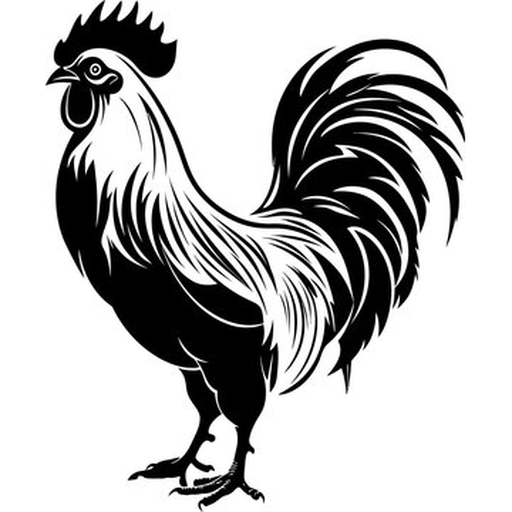

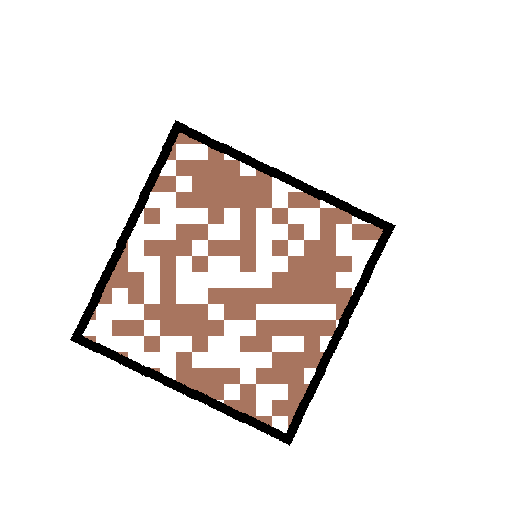

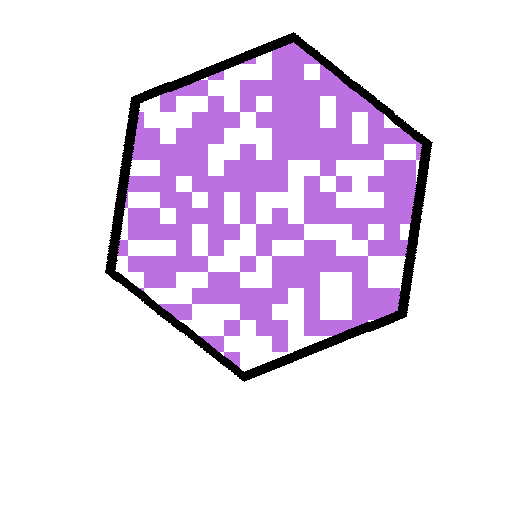

In [50]:
# Inpect failed distractor trials
df_failed = trial_df[
    (trial_df["task_type"] == "color_judgment") &
    (trial_df["exit_reason"] == "failed_distractor") &
    (trial_df["target_color"] != trial_df["response_label"]) &
    (trial_df["response_label"] != "white")
].copy()

print(f"Number of failed trials: {len(df_failed)}")
display(df_failed[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_failed.head(3).iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

## Succesfull completions

In [51]:
# Extract only valid color judgments for analysis)
df_complete = trial_df[
    (trial_df["task_type"] == "color_judgment") &
    (trial_df["exit_reason"] == "completed") 
].copy()

# Drop emtpy columns (those cary information for introspection or attention checks)
before = df_complete.shape[1]
df_complete = df_complete.dropna(axis=1, how="all")
after = df_complete.shape[1]

print(f"Dropped {before - after} empty columns")

len(df_complete)

Dropped 10 empty columns


17300

In [59]:
df_complete.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_trial_completed.csv", index=False)

In [ ]:
df_complete["study_type"].value_counts()

In [52]:
image_counts = (
    df_complete[df_complete["exit_reason"] == "completed"]
    .groupby(["stimulus_type", "image_path"])
    .size()
    .reset_index(name="n_shown")
)
image_counts.sort_values("n_shown")


,stimulus_type,image_path,n_shown
2993,shape,shapes/shape_colored/triangle_v4_purple/FG_100...,2
2988,shape,shapes/shape_colored/triangle_v4_purple/FG_050...,2
40,correct_prior,color_images/gpt-4o/image_priors/Komodo_dragon...,2
2935,shape,shapes/shape_colored/triangle_v3_purple/FG_060...,2
2945,shape,shapes/shape_colored/triangle_v3_yellow/FG_060...,2
...,...,...,...
686,correct_prior,color_images/gpt-4o/image_priors/jack-o'-lante...,20
993,correct_prior,color_images/gpt-4o/image_priors/sardine_4_1cf...,20
1213,correct_prior,color_images/gpt-4o/image_priors/waffle_iron_1...,20
2280,shape,shapes/shape_colored/pentagon_v1_orange/FG_000...,20


Number of warnings (wrong responses): 33


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path
429,6658b32dd8c3da854c842802,great white shark,FG,0.0,white,blue,color_images/gpt-4o/image_priors/great_white_s...
1146,63f77a5dde1ea03305e119e0,cockroach,FG,55.0,brown,blue,color_images/gpt-4o/image_priors/cockroach_1_0...
1519,5f25e860dd98342ce97e7403,camel,FG,5.0,brown,blue,color_images/gpt-4o/image_priors/camel_1_d4d47...
1865,67680e24c4684ebbc6ec8af3,circle,BG,40.0,white,red,shapes/shape_colored/circle_v0_purple/BG_040_s...
1931,574da26c7f1e770007f42d11,frilled lizard,FG,0.0,white,blue,color_images/gpt-4o/image_priors/frilled_lizar...
3168,6978c580d801e64f18d9e3ab,giraffe,FG,70.0,brown,blue,color_images/gpt-4o/image_priors/giraffe_1_785...
3352,58f669cefb4d7500014af69b,gas pump,FG,10.0,red,green,color_images/gpt-4o/image_priors/gas_pump_5_be...
3808,673f6ffebce20832346325de,keyboard,FG,30.0,brown,blue,color_images/gpt-4o/image_priors/keyboard_(mus...
3931,5bf1c9d332cb3b0001f6f1c3,hexagon,FG,30.0,pink,green,shapes/shape_colored/hexagon_v1_pink/FG_030_se...
4056,62cbfe7dd820cc9d2cd7c87a,gas pump,FG,70.0,red,green,color_images/gpt-4o/image_priors/gas_pump_5_be...


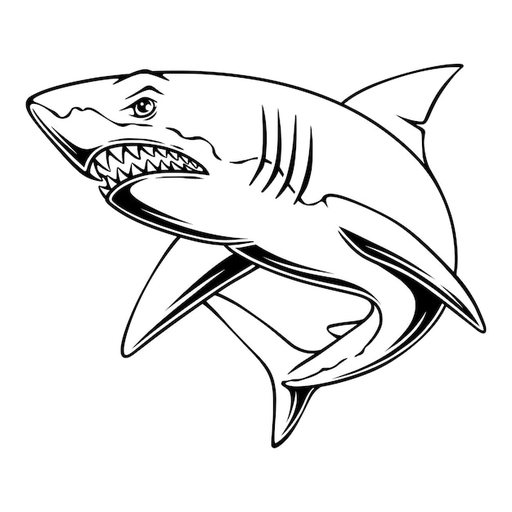

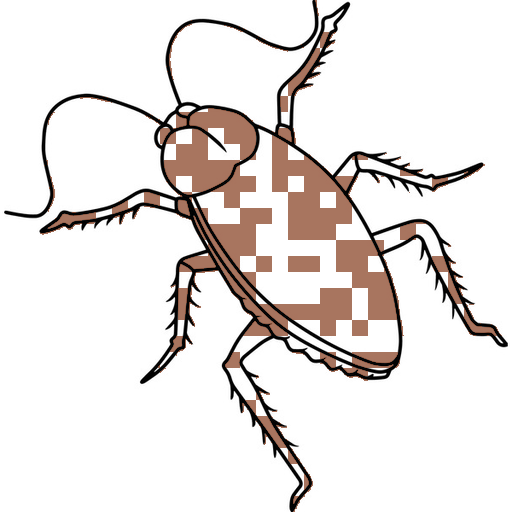

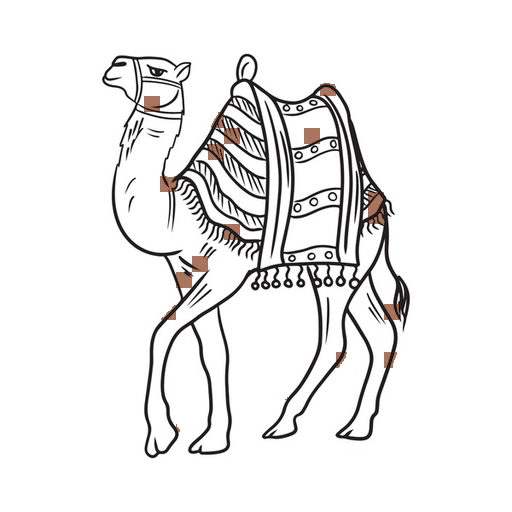

In [53]:
# Warnings
df_warnings = df_complete[(df_complete["target_color"] != df_complete["response_label"]) &
            (df_complete["response_label"] != "white")]

print(f"Number of warnings (wrong responses): {len(df_warnings)}")
display(df_warnings[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_warnings.head(3).iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

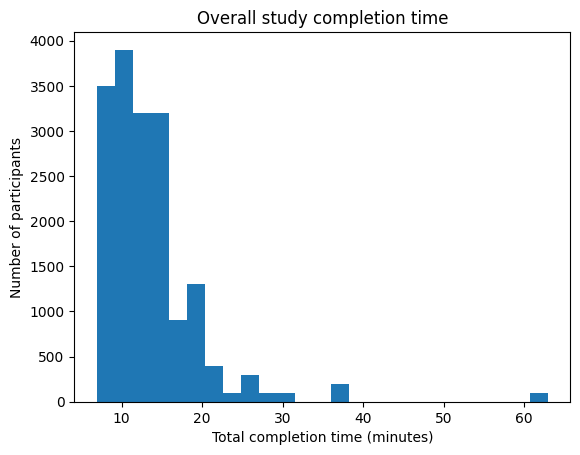

In [54]:
# Participant-level completion time (minutes) 
df_complete['experiment_start_time'] = pd.to_datetime(
    df_complete['experiment_start_time'], unit='ms'
)
df_complete['exit_time'] = pd.to_datetime(
    df_complete['exit_time'], unit='ms'
)

df_complete['total_time_min'] = (
    df_complete['exit_time'] - df_complete['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_complete['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [55]:
df_complete.sort_values("total_time_min", ascending=False)[
    ["PROLIFIC_PID", "profile_id", "total_time_min"]
].head(10)


,PROLIFIC_PID,profile_id,total_time_min
15806,6658b14931847f8a05c3d266,profile_21_last,62.9301
15805,6658b14931847f8a05c3d266,profile_21_last,62.9301
15787,6658b14931847f8a05c3d266,profile_21_last,62.9301
15786,6658b14931847f8a05c3d266,profile_21_last,62.9301
15793,6658b14931847f8a05c3d266,profile_21_last,62.9301
15792,6658b14931847f8a05c3d266,profile_21_last,62.9301
15825,6658b14931847f8a05c3d266,profile_21_last,62.9301
15824,6658b14931847f8a05c3d266,profile_21_last,62.9301
15814,6658b14931847f8a05c3d266,profile_21_last,62.9301
15813,6658b14931847f8a05c3d266,profile_21_last,62.9301


In [56]:
trial_df[trial_df["variant_region"] == "BG"]["target_color"].value_counts()

target_color
white    1774
Name: count, dtype: int64

In [57]:
trial_df.columns

Index(['PROLIFIC_PID', 'certainty_change_count', 'color_time',
       'correct_response', 'distractor_errors', 'exit_reason', 'exit_time',
       'experiment_start_time', 'final_certainty', 'finish_time',
       'first_certainty_time', 'image_path', 'initial_certainty',
       'internal_node_id', 'intro_position', 'is_distractor', 'object',
       'passed', 'percent_colored', 'profile_id', 'profile_index',
       'question_order', 'response', 'response_index', 'response_label', 'rt',
       'sanity_id', 'second_certainty_time', 'session_id', 'slider_start',
       'stimulus', 'stimulus_type', 'study_id', 'study_type', 'subject_id',
       'target_color', 'task_type', 'time_elapsed', 'timed_out',
       'timeout_time', 'trial_index', 'trial_type', 'variant_region',
       'view_history', 'manipulation_color_x', 'target_color_stimulus_x',
       'manipulation_color_y', 'target_color_stimulus_y',
       'manipulation_color'],
      dtype='object')

In [58]:
trial_df[trial_df["variant_region"] == "BG"]["manipulatn_color"].value_counts()

KeyError: 'manipulatn_color'

### Accuracy vs. coloring fraction

In [ ]:
# Accuracy: response must match target_color
df_complete.loc[df_complete["variant_region"] == "BG", "target_color"] = "white" # Fix wrong labels for BG, will be fixed in future study runs
df_complete["accuracy"] = (df_complete["response_label"] == df_complete["target_color"]).astype(float)
df_complete["accuracy"].mean()

np.float64(0.7701734104046243)

In [ ]:
grouped = df_complete.groupby(["variant_region", "percent_colored"])

summary = grouped["accuracy"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# Optional: 95% CI
summary["ci"] = (
    stats.t.ppf(0.975, summary["n"] - 1)
    * (summary["std"] / np.sqrt(summary["n"]))
)


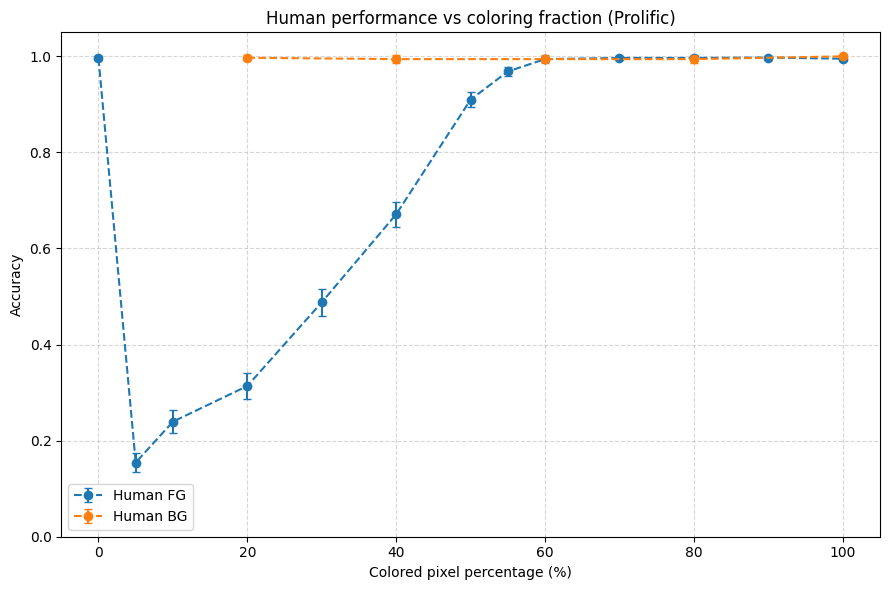

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = summary[summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o--",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Human performance vs coloring fraction (Prolific)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


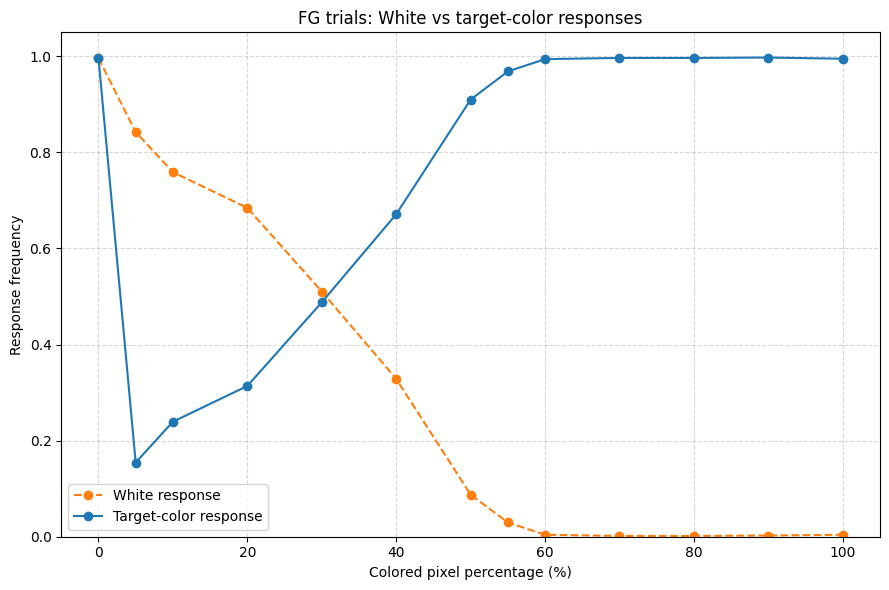

In [ ]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

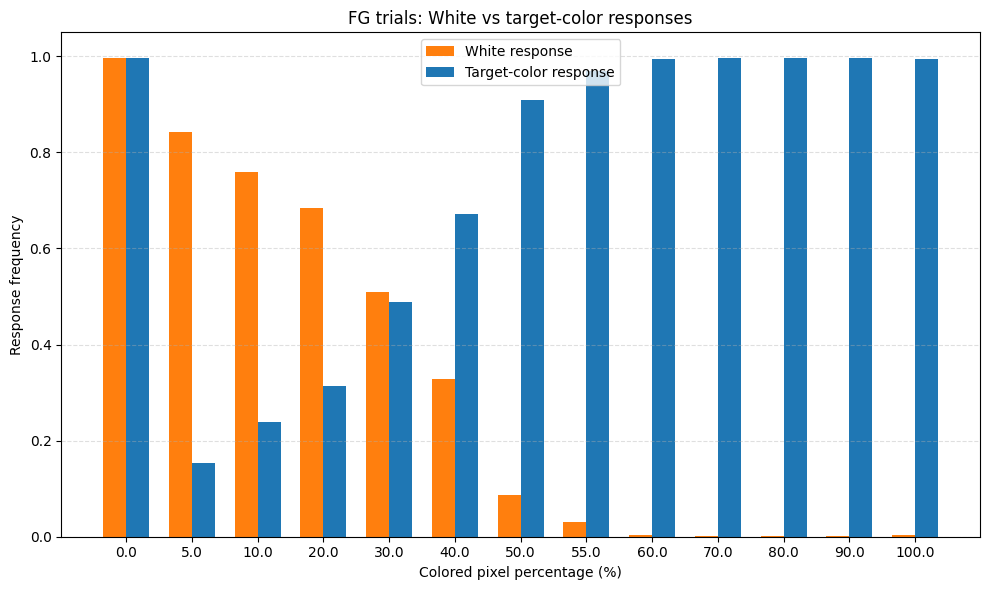

In [ ]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


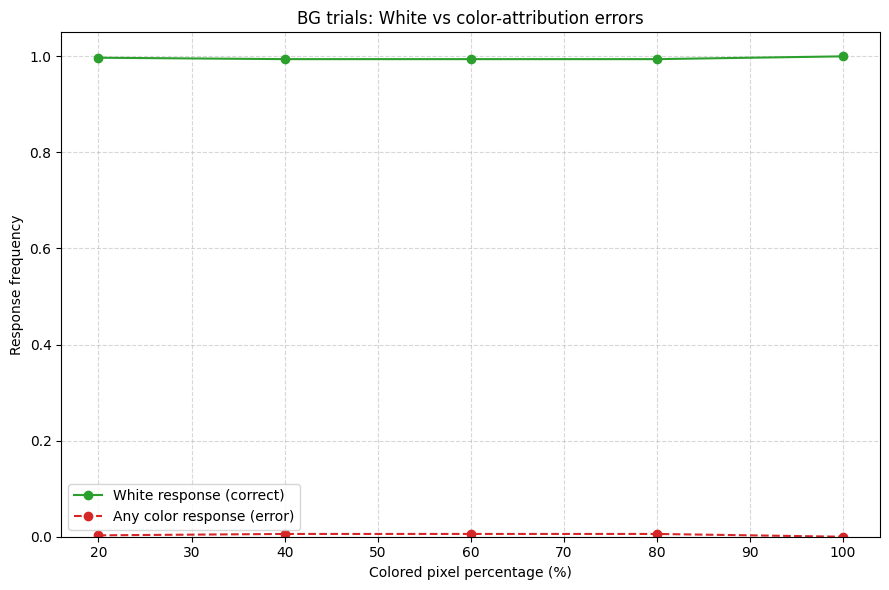

In [ ]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

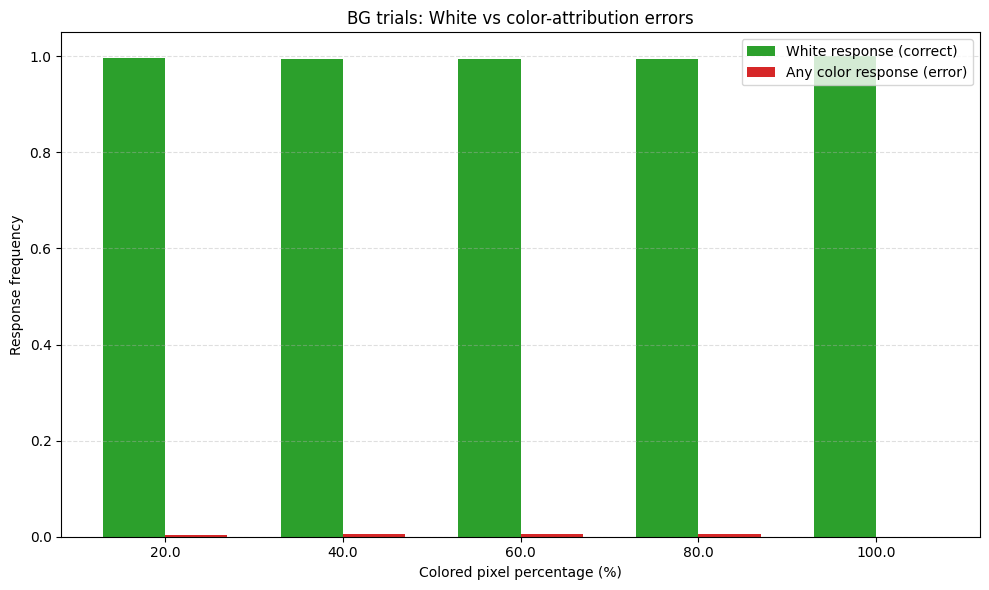

In [ ]:
x = np.arange(len(bg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    bg_summary["p_white"],
    width,
    label="White response (correct)",
    color="#2ca02c",
)

ax.bar(
    x + width / 2,
    bg_summary["p_colored"],
    width,
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xticks(x)
ax.set_xticklabels(bg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Certainty vs. coloring fraction

In [ ]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(["variant_region", "percent_colored"])
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat([initial_summary, final_summary], ignore_index=True)

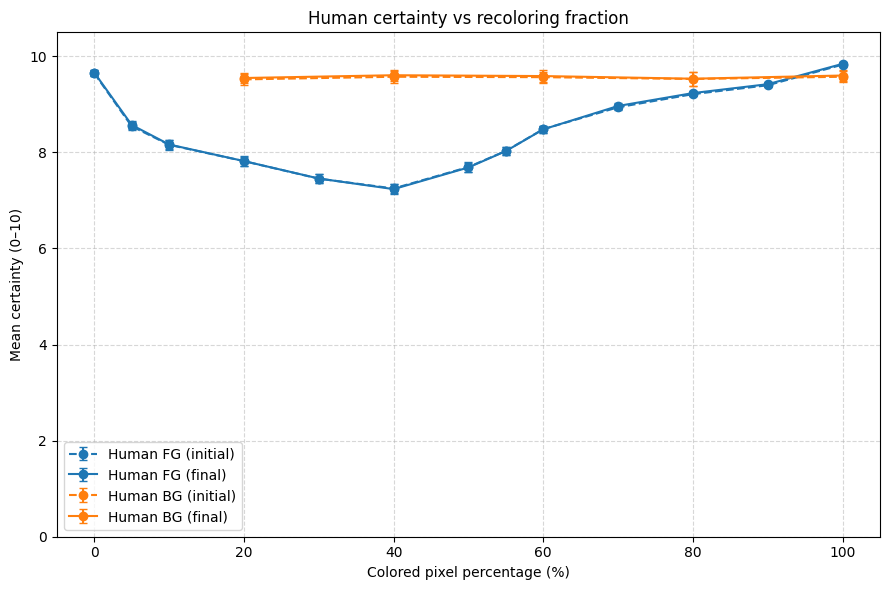

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "Human FG (initial)",
    ("FG", "final_certainty"): "Human FG (final)",
    ("BG", "initial_certainty"): "Human BG (initial)",
    ("BG", "final_certainty"): "Human BG (final)",
}

for region in ["FG", "BG"]:
    for cert_type in ["initial_certainty", "final_certainty"]:
        sub = cert_summary[
            (cert_summary["variant_region"] == region) &
            (cert_summary["certainty_type"] == cert_type)
        ]

        if sub.empty:
            continue

        ax.errorbar(
            sub["percent_colored"],
            sub["mean"],
            yerr=sub["ci"],
            fmt="o",
            linestyle=linestyles[cert_type],
            color=colors[region],
            capsize=3,
            label=labels[(region, cert_type)],
        )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Mean certainty (0–10)")
ax.set_ylim(0, 10.5)
ax.set_title("Human certainty vs recoloring fraction")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Response times

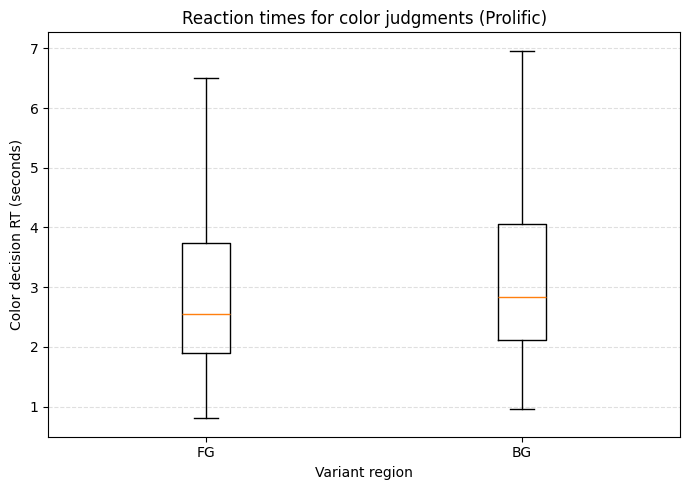

In [ ]:
df_rt = df_complete.copy()

# ms → seconds
df_rt["color_time"] = df_rt["color_time"] / 1000

# keep valid RTs only
df_color_rt = df_rt[
    df_rt["color_time"].notna() &
    (df_rt["color_time"] > 0)
]

groups = [
    df_color_rt.loc[df_color_rt["variant_region"] == "FG", "color_time"].values,
    df_color_rt.loc[df_color_rt["variant_region"] == "BG", "color_time"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(
    groups,
    tick_labels=["FG", "BG"],
    showfliers=False,
)

plt.xlabel("Variant region")
plt.ylabel("Color decision RT (seconds)")
plt.title("Reaction times for color judgments (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
df_rt["final_certainty_time"] = df_rt["second_certainty_time"].fillna(
    df_rt["first_certainty_time"]
)

df_rt["rt_certainty_tot_sec"] = (
    (df_rt["final_certainty_time"] - df_rt["color_time"]) / 1000
)

df_rt = df_rt[
    df_rt["rt_certainty_tot_sec"].notna() &
    (df_rt["rt_certainty_tot_sec"] > 0)
]

df_rt["rt_certainty_revision_sec"] = (
    (df_rt["second_certainty_time"] - df_rt["first_certainty_time"]) / 1000
)

df_revision = df_rt[
    df_rt["rt_certainty_revision_sec"].notna() &
    (df_rt["rt_certainty_revision_sec"] > 0)
]

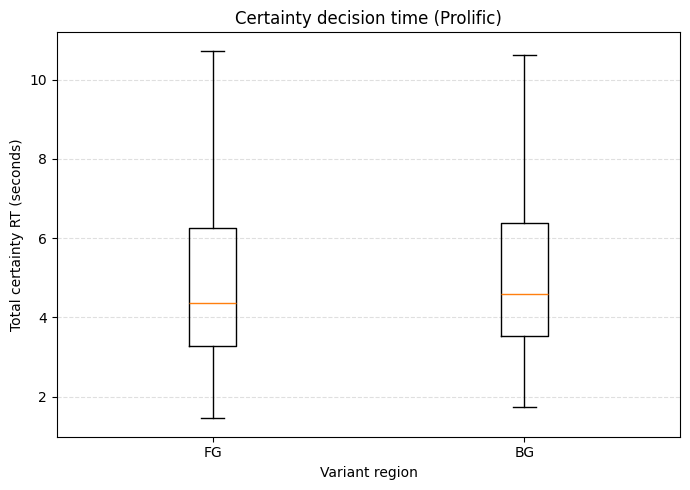

In [ ]:
groups = [
    df_rt[df_rt["variant_region"] == "FG"]["rt_certainty_tot_sec"].values,
    df_rt[df_rt["variant_region"] == "BG"]["rt_certainty_tot_sec"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(groups, tick_labels=["FG", "BG"], showfliers=False)
plt.xlabel("Variant region")
plt.ylabel("Total certainty RT (seconds)")
plt.title("Certainty decision time (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
rev_rate = (
    df_complete["second_certainty_time"].notna()
    .groupby(df_complete["variant_region"])
    .mean()
)

print(rev_rate)

variant_region
BG    0.03526
FG    0.05639
Name: second_certainty_time, dtype: float64


## Introspection question

In [ ]:
df[df["task_type"] == "introspection"][["intro_position","response", "slider_start"]]


,intro_position,response,slider_start
106,last,78,50.0
108,first,73,50.0
320,last,51,50.0
427,last,72,50.0
535,last,55,50.0
...,...,...,...
18839,last,15,50.0
18841,first,64,50.0
18846,first,40,50.0
18953,first,64,50.0


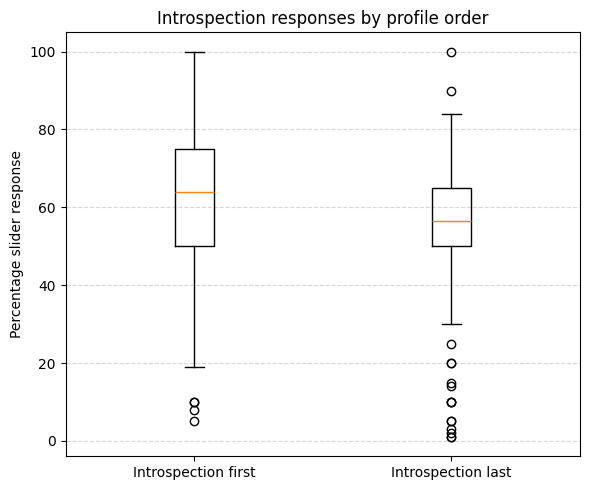

In [ ]:
# Keep only introspection trials
df_intro = df[
    (df["task_type"] == "introspection") &
    (df["intro_position"].isin(["first", "last"]))
].copy()

groups = [
    df_intro[df_intro["intro_position"] == "first"]["response"].dropna(),
    df_intro[df_intro["intro_position"] == "last"]["response"].dropna(),
]

plt.figure(figsize=(6, 5))
plt.boxplot(
    groups,
    tick_labels=["Introspection first", "Introspection last"],
    showfliers=True,
)

plt.ylabel("Percentage slider response")
plt.title("Introspection responses by profile order")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

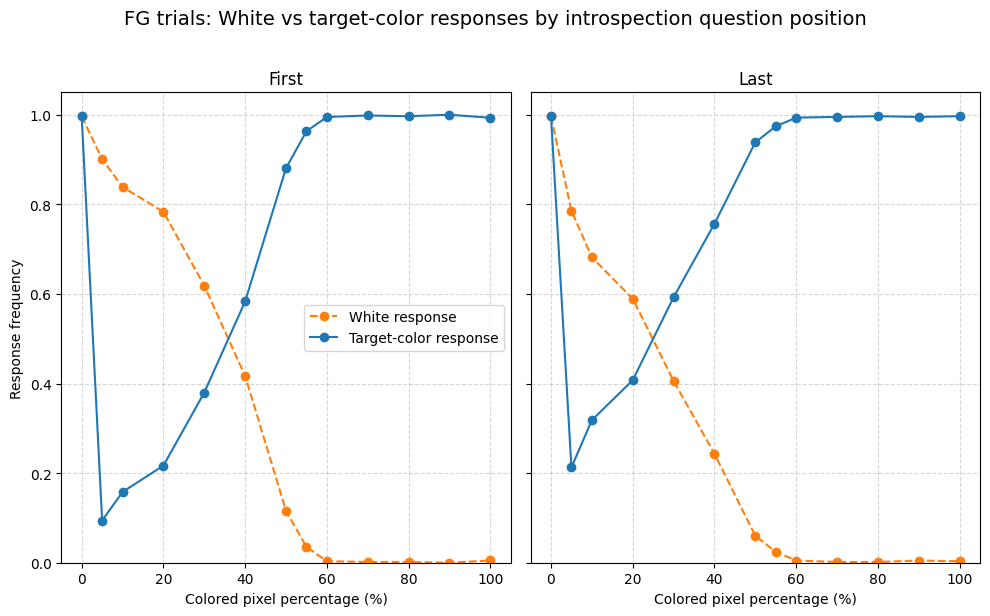

In [ ]:
df_fg = df_complete[
    (df_complete["variant_region"] == "FG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by introspection question position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_fg[df_fg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


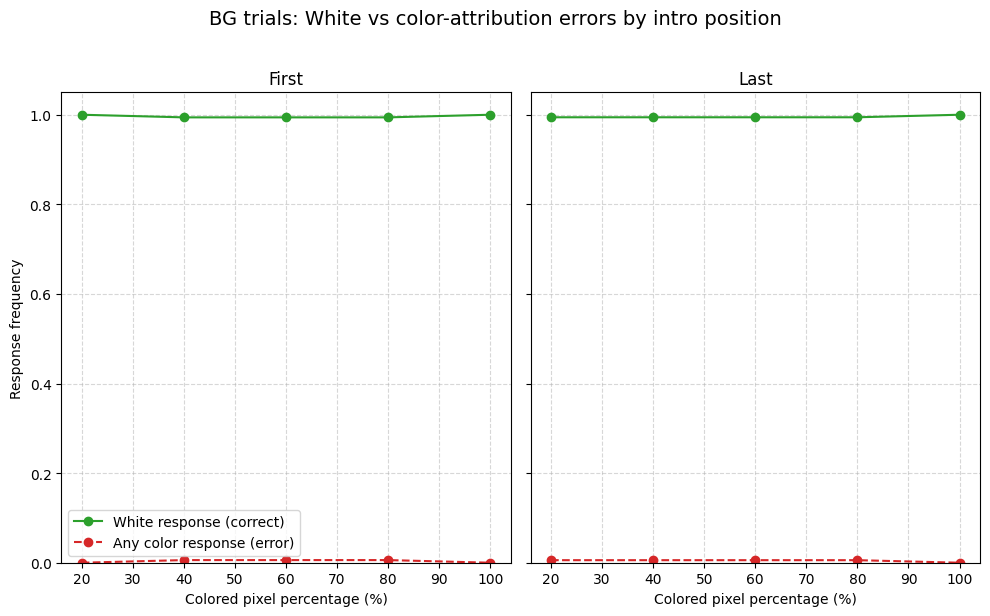

In [ ]:
df_bg = df_complete[
    (df_complete["variant_region"] == "BG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_bg[df_bg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()

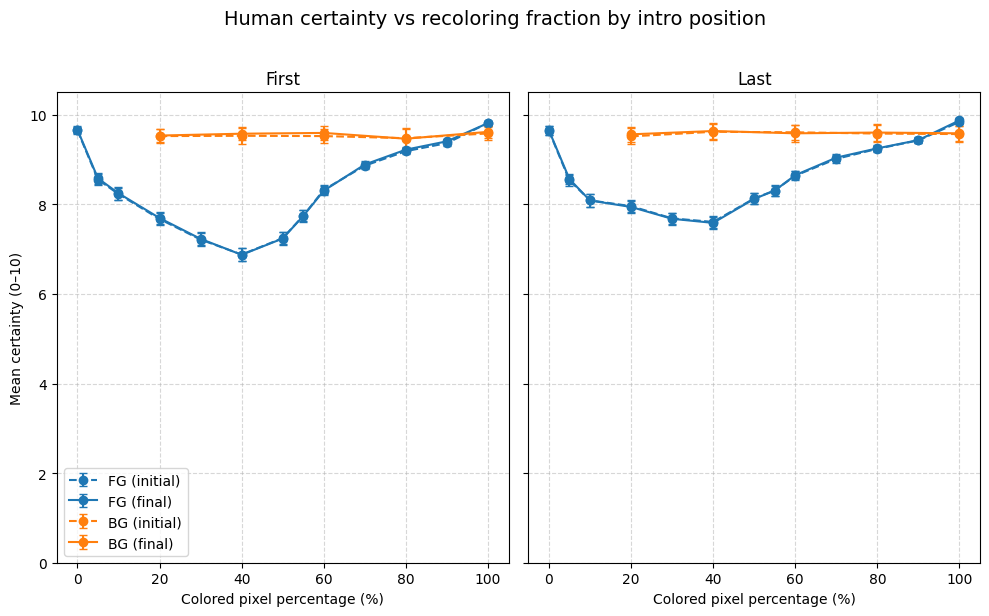

In [ ]:
df_cert = df_complete[
    df_complete["intro_position"].isin(["first", "last"])
].copy()

df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["intro_position", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

cert_summary = pd.concat(
    [
        summarize_certainty(df_cert, "initial_certainty"),
        summarize_certainty(df_cert, "final_certainty"),
    ],
    ignore_index=True
)

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs recoloring fraction by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

colors = {"FG": "#1f77b4", "BG": "#ff7f0e"}
linestyles = {"initial_certainty": "--", "final_certainty": "-"}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, pos in zip(axes, intro_positions):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["intro_position"] == pos) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()


## Split by stimulus type

In [ ]:
df_complete.stimulus_type.value_counts()

stimulus_type
correct_prior    7612
shape            7612
counterfact      2076
Name: count, dtype: int64

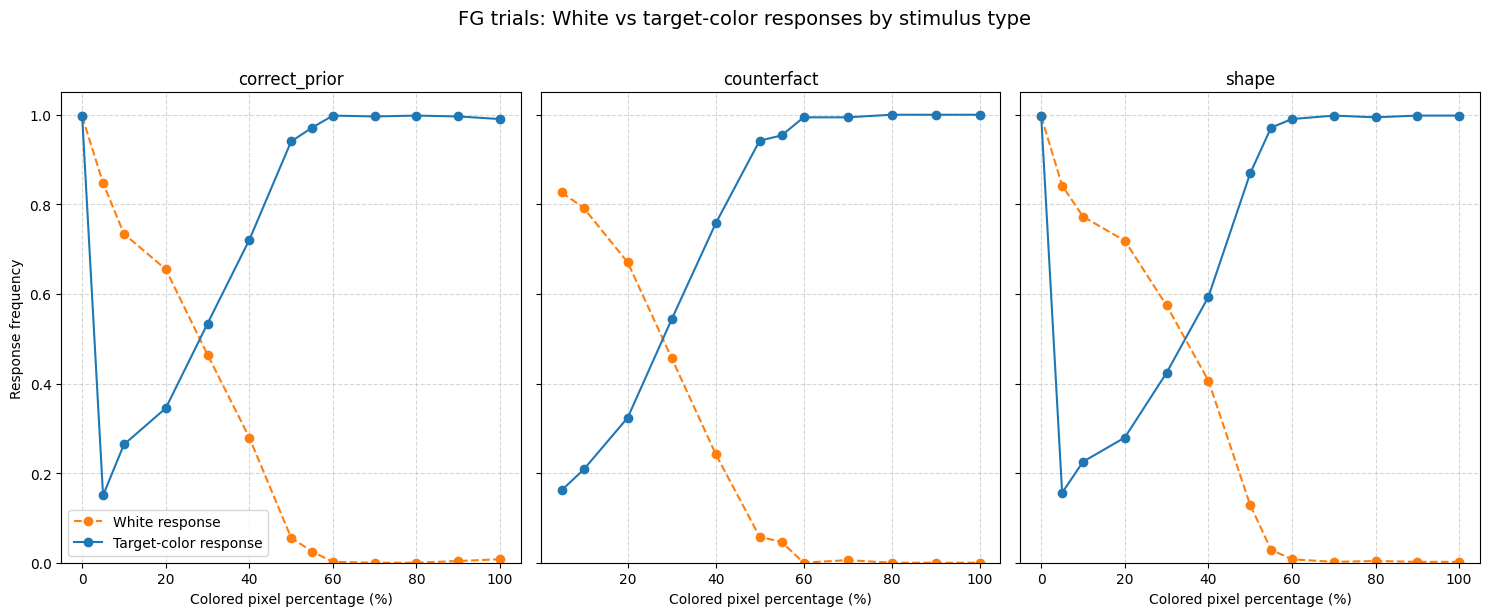

In [ ]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

stimulus_types = sorted(df_fg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_fg[df_fg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


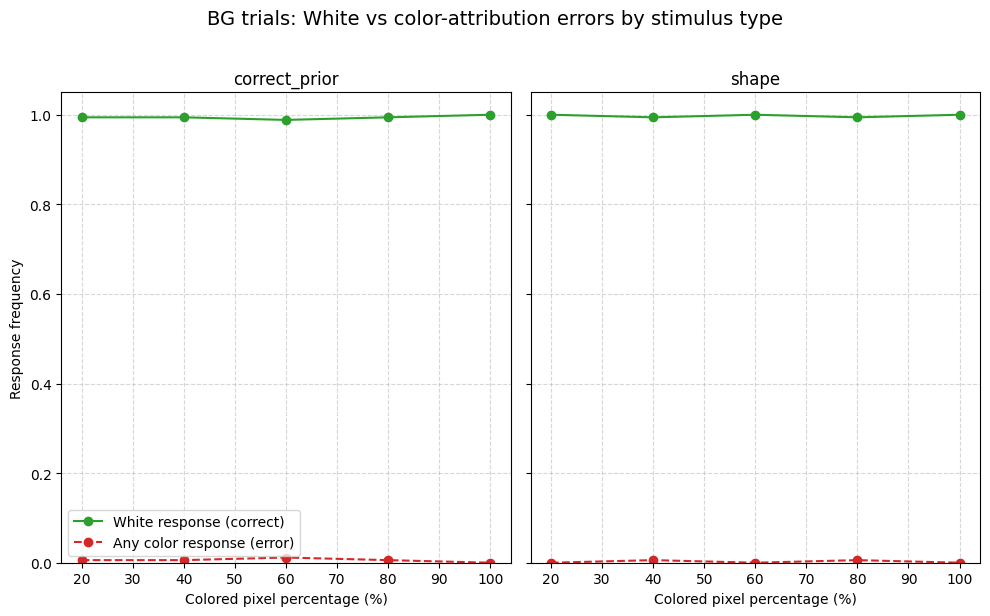

In [ ]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

stimulus_types = sorted(df_bg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_bg[df_bg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


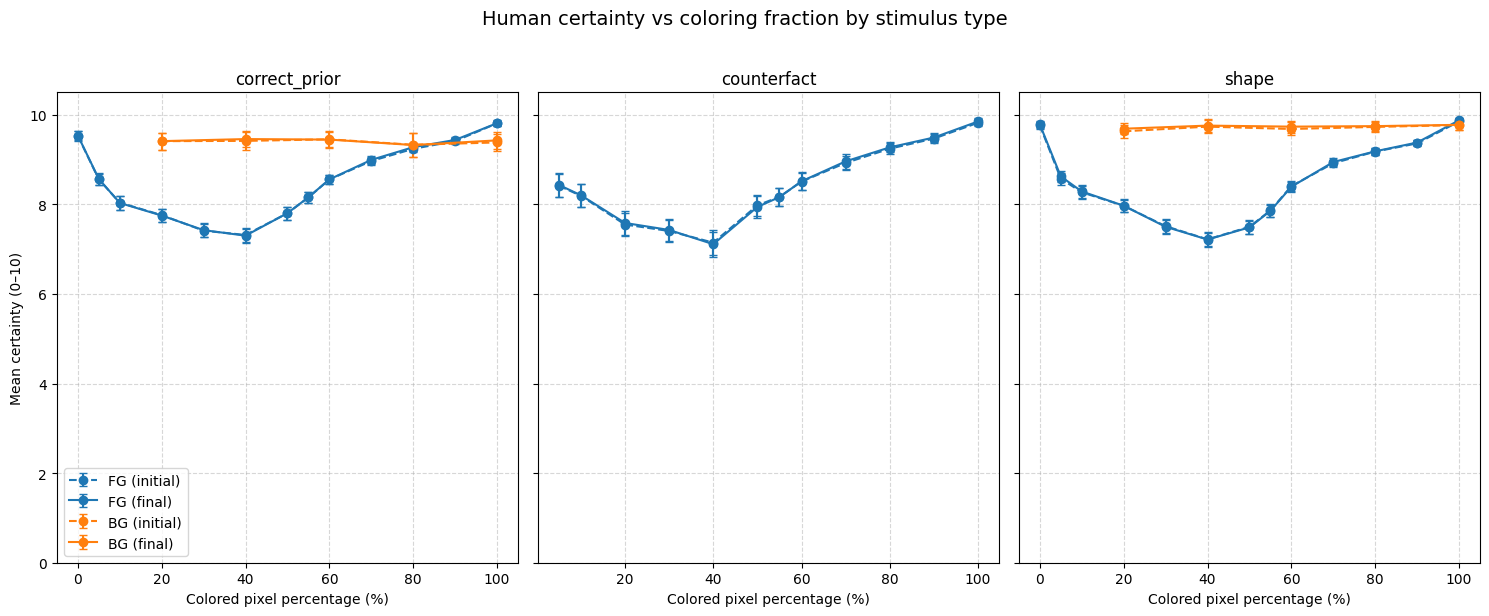

In [ ]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["stimulus_type", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat(
    [initial_summary, final_summary],
    ignore_index=True
)

stimulus_types = sorted(df_cert["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs coloring fraction by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, stim in zip(axes, stimulus_types):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["stimulus_type"] == stim) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()